# benchmark simple sum dataset using grok single function inference  

This is the second notebook using groq inference endpoint.  
Previously, we attempted to compare models using tool calling, but it didn't work because some models couldn't reliably call the JSON schema, and also because the token usage was too high for the API rate limits in place.  

This time, we hope to achive our goals by only asking for a single token as a response. We will then cast this token to an integer and measure the result.  

## install libs

In [1]:
!pip install groq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

## define inference function

In [56]:
from google.colab import userdata
from groq import BadRequestError, RateLimitError
from groq import Groq
import os
import json

client = Groq(api_key = userdata.get('GROQ_API_KEY'))

import time

def safe_int_conversion(x):
    try:
        return int(x)
    except (ValueError, TypeError):
        return 0

def get_sum_result(current_sum, curr_model):
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # Step 1: send the conversation and available functions to the model
            messages = [
                {
                    "role": "system",
                    "content": "You are a helpful assistant. Answer using a single token."
                },
                {
                    "role": "user",
                    "content": f"What is the result of this sum : {current_sum} ?",
                }
            ]
            response = client.chat.completions.create(
                model=curr_model,
                messages=messages,
                max_tokens=2,
                temperature=0
            )

            response_message = response.choices[0].message.content
            return safe_int_conversion(response_message)

        except RateLimitError as e:
                time.sleep(1)
        except BadRequestError as e:
            if attempt < max_retries - 1:
                time.sleep(1)
                continue
            else:
                raise Exception("Max retries exceeded") from e

model_name = 'llama3-8b-8192'
# model_name = 'llama3-70b-8192'
# model_name = 'mixtral-8x7b-32768',
result = get_sum_result("50+50", model_name)
print(result)


100


In [22]:
# THIS FUNCTION WORKS!!!
# JSON MODE IS DIFFERENT FROM TOOL CALLING
# WE HAVE TO TRY IT IN ANOTHER NOTEBOOK

# from typing import List, Optional
# import json

# from pydantic import BaseModel
# from groq import Groq

# client = Groq(api_key = userdata.get('GROQ_API_KEY'))

# class Result(BaseModel):
#     sum_result: int


# def get_sum_result_json_mode(current_sum: str) -> Result:
#     chat_completion = client.chat.completions.create(
#         messages=[
#             {
#                 "role": "system",
#                 "content": "You are given a sum to compute and write the answer in JSON.\n"
#                 # Pass the json schema to the model. Pretty printing improves results.
#                 f" The JSON object must use the schema: {json.dumps(Result.model_json_schema(), indent=2)}",
#             },
#             {
#                 "role": "user",
#                 "content": f"What is the result of this sum : {current_sum}",
#             },
#         ],
#         model="llama3-8b-8192",
#         temperature=0,
#         # Streaming is not supported in JSON mode
#         stream=False,
#         # Enable JSON mode by setting the response format
#         response_format={"type": "json_object"},
#     )
#     return int(Result.model_validate_json(chat_completion.choices[0].message.content).sum_result)



2

## define benchmark related functions

In [42]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


## Load dataset

In [27]:
from datasets import load_dataset

dataset_ds = load_dataset("the-french-artist/repetitive_sums_benchmark", split='train')
dataset_ds

Generating train split:   0%|          | 0/99 [00:00<?, ? examples/s]

Dataset({
    features: ['sum', 'result'],
    num_rows: 99
})

In [30]:
additions_df = dataset_ds.to_pandas()

## Run complete dataset inference

In [47]:
# USING GROQ: we hit either severe rate limits, or an inability to use tools correctly.
models_to_test = [
  'gemma-7b-it',
  'mixtral-8x7b-32768',
  'llama3-8b-8192',
  'llama3-70b-8192',
]

number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,gemma-7b-it,mixtral-8x7b-32768,llama3-8b-8192,llama3-70b-8192
0,1+1,2,2.0,2.0,2.0,2.0
1,1+1+1,3,3.0,3.0,3.0,3.0
2,1+1+1+1,4,4.0,4.0,4.0,4.0
3,1+1+1+1+1,5,5.0,0.0,5.0,5.0
4,1+1+1+1+1+1,6,6.0,0.0,6.0,6.0


In [48]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,gemma-7b-it,15.151515,30.812500,27.5,21.470081,1.0,70.0,0
1,mixtral-8x7b-32768,4.040404,52.887500,51.5,25.832956,10.0,99.0,9
2,llama3-8b-8192,16.161616,28.750000,25.5,22.193167,1.0,69.0,0
3,llama3-70b-8192,17.171717,28.228571,26.0,21.780307,1.0,70.0,0


<ipython-input-42-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


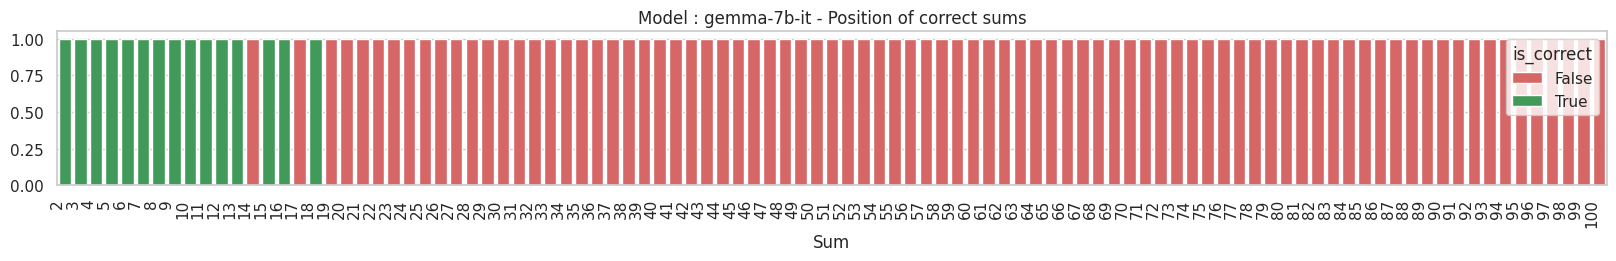

<ipython-input-42-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


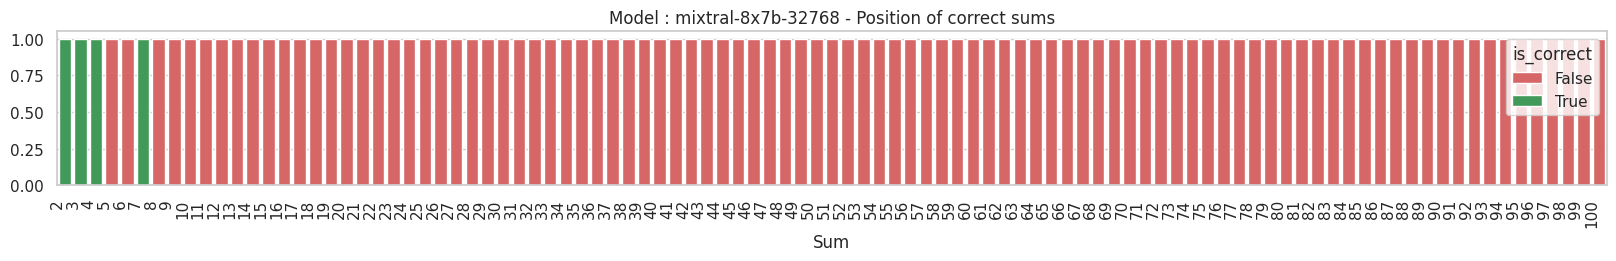

<ipython-input-42-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


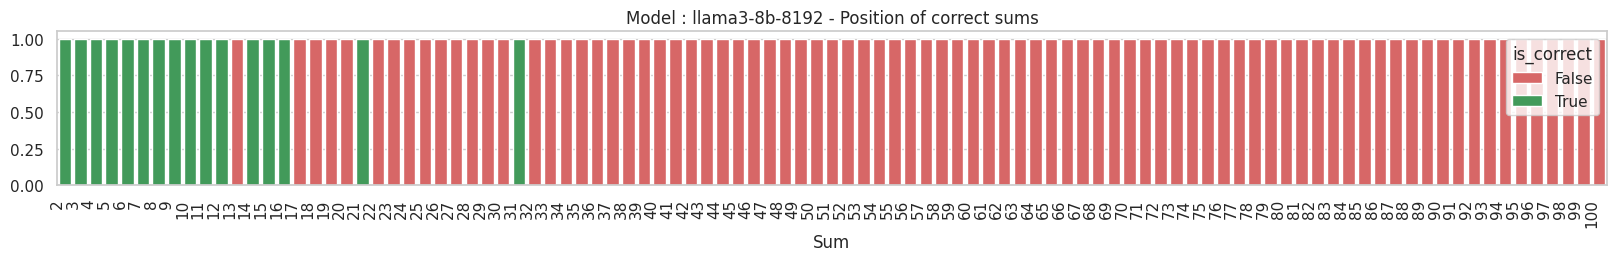

<ipython-input-42-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


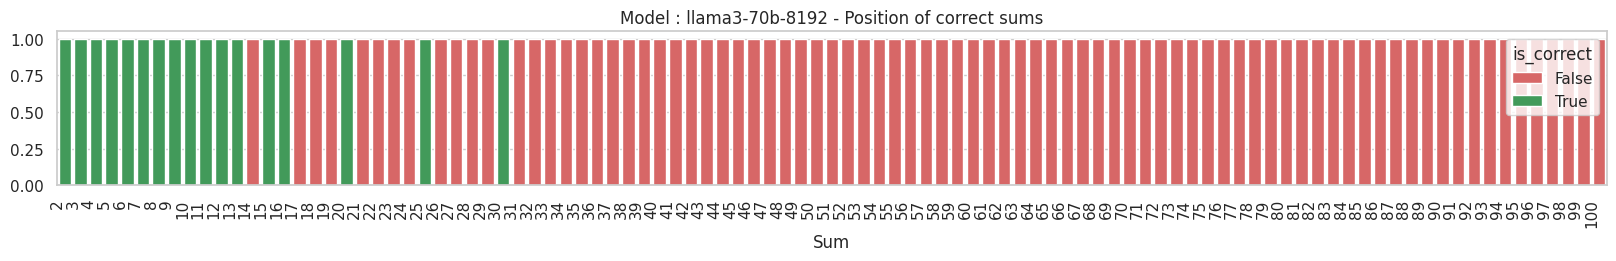

In [49]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)

In [51]:
benchmark_df.head(100)

,sum,result,gemma-7b-it,mixtral-8x7b-32768,llama3-8b-8192,llama3-70b-8192,is_correct
0,1+1,2,2.0,2.0,2.0,2.0,True
1,1+1+1,3,3.0,3.0,3.0,3.0,True
2,1+1+1+1,4,4.0,4.0,4.0,4.0,True
3,1+1+1+1+1,5,5.0,0.0,5.0,5.0,True
4,1+1+1+1+1+1,6,6.0,0.0,6.0,6.0,True
...,...,...,...,...,...,...,...
94,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,96,30.0,1.0,31.0,30.0,False
95,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,97,30.0,NaN,31.0,NaN,False
96,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,98,30.0,5.0,31.0,30.0,False
97,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,99,30.0,5.0,31.0,30.0,False


## Conclusion

We find that using 1 or 2 tokens allows LLAMA to answer from 0 to 100.  
Mixtral seems to need more tokens, we had to raise the answer from a single token to 2 tokens so we could get a single digit number.  

Due to rate limits, we cannot make more tests right now, maybe we could achieve better Mixtral results by raising the allowed token count.  